In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import datetime
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.colors import from_levels_and_colors
#from matplotlib.colors import DivergingNorm
from matplotlib.colors import TwoSlopeNorm
from cartopy.util import add_cyclic_point
import cartopy as cart
from skyfield import api
from scipy.ndimage import uniform_filter1d
from scipy import signal
from scipy.signal import find_peaks
import seaborn as sns
from numpy.polynomial import Polynomial

In [2]:
# Sea ice area 
si_m = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_97_NH_ym_gridarea_fldsum.nc')
si_novolc_m = xr.open_dataset('novolc/slo0043_echam6_BOT_mm_1001-8850_97_NH_ym_gridarea_fldsum.nc')

# SST
sst_NA_m = xr.open_dataset('slo0050_mpiom_tos_1dg_ym_1001-8850_NNA_fldmean.nc')
sst_NA_novolc_m = xr.open_dataset('novolc/slo0043_mpiom_tos_1dg_ym_1001-8850_NNA_fldmean.nc')

# OHC
ohc_zm = xr.open_dataset('slo0050_total_heatcontent_700m_ym_1001-8850_regridded_zm.nc')
ohc_novolc = xr.open_dataset('novolc/slo0043_total_heatcontent_700m_ym_1001-8850_regridded.nc')

# MOC
moc = xr.open_dataset('slo0042+slo0046+slo0050_mpiom_atlantic_moc_ym_1001-8850.nc')
#moc_26N_novolc = xr.open_dataset('novolc/slo0043_mpiom_amoc_26N_ym_1001-8850.nc')

# BTS
BTS_NA_m = xr.open_dataset('slo0050_mpiom_psi_1dg_ym_1001-8850_NNA_fldmean.nc')
BTS_NA_novolc_m = xr.open_dataset('novolc/slo0043_mpiom_psi_1dg_ym_1001-8850_NNA_fldmean.nc')

# Atlantic heat flux
atl_hfl = xr.open_dataset('slo0042+slo0046+slo0050_mpiom_atlantic_hfl_ym_1001-8850.nc')
atl_hfl_novolc = xr.open_dataset('novolc/slo0043_mpiom_atlantic_hfl_ym_1001-8850.nc')

# TAS
tas_NH = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_167_NH_ymean_fldmean.nc')

# AOD
aod = xr.open_dataset('forcing/eva_holo2.2_aod_550nm_echam_T63_sw_1001_8850_ym.nc')

/opt/homebrew/anaconda3/envs/Holocene/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/homebrew/anaconda3/envs/Holocene/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/opt/homebrew/anaconda3/envs/Holocene/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/homebrew/anaconda3/envs/Holocene/lib/p

In [3]:
ts = api.load.timescale()
time = ts.tt(range(-6000, 1850)) 
time = time.tt_calendar()[0]

In [4]:
time_200acc = time[200:]
time_100acc = time[100:]
time_50acc = time[50:]
time_10acc = time[10:]

In [5]:
def get_wghts(lat):

	latr = np.deg2rad(lat) # convert to radians

	weights = np.cos(latr) # calc weights

	return weights

In [6]:
lat = aod['lat'][:48]
wgts = get_wghts(lat)

aod_awa = np.average(aod['aod550'][:,:48], axis=1, weights=wgts)

In [7]:
BTS_NA_m = BTS_NA_m['psitro']/1000000/1025
BTS_NA_novolc_m = BTS_NA_novolc_m['psitro']/1000000/1025 

In [8]:
atl_hfl_NA_mean = np.mean(atl_hfl['atlantic_hfl'][:,0,90:,0],axis=1)
atl_hfl_NA_novolc_mean = np.mean(atl_hfl_novolc['atlantic_hfl'][:,0,90:,0],axis=1)

In [9]:
# Detrend
moc_60N_detr = signal.detrend(moc['atlantic_moc'][:,0,150,0], axis=0)
#moc_nv_detr = signal.detrend(moc_novolc['atlantic_moc'], axis=0)

si_detr = signal.detrend(si_m['var97'], axis=0)
si_nv_detr = signal.detrend(si_novolc_m['var97'], axis=0)

sst_NA_detr = signal.detrend(sst_NA_m['tos'], axis=0)
sst_NA_nv_detr = signal.detrend(sst_NA_novolc_m['tos'], axis=0)

atl_hfl_detr = signal.detrend(atl_hfl_NA_mean, axis=0)
atl_hfl_nv_detr = signal.detrend(atl_hfl_NA_novolc_mean, axis=0)

tas_NH_detr = signal.detrend(tas_NH['var167'], axis=0)

ohc_detr = signal.detrend(np.mean(ohc_zm['heatcontent'][:,:],axis=1), axis=0)

bts_detr = signal.detrend(BTS_NA_m, axis=0)
bts_nv_detr = signal.detrend(BTS_NA_novolc_m, axis=0)

/opt/homebrew/anaconda3/envs/Holocene/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
# Detrend using polynomal fit
poly = Polynomial.fit(time, tas_NH['var167'][:,0,0], deg=2)
tas_NH_detr_2 = tas_NH['var167'][:,0,0] - poly(time)

In [11]:
# Running mean
moc_60N_detr_10yr = uniform_filter1d(moc_60N_detr, size=10, axis=0, origin=0)
moc_60N_detr_50yr = uniform_filter1d(moc_60N_detr, size=50, axis=0, origin=0)
moc_60N_detr_100yr = uniform_filter1d(moc_60N_detr, size=100, axis=0, origin=0)
moc_60N_detr_200yr = uniform_filter1d(moc_60N_detr, size=200, axis=0, origin=0)
#moc_26N_nv_detr_200yr = uniform_filter1d(moc_26N_nv_detr, size=200, axis=0, origin=0)

si_detr_10yr = uniform_filter1d(si_detr, size=10, axis=0, origin=0)
si_detr_50yr = uniform_filter1d(si_detr, size=50, axis=0, origin=0)
si_detr_100yr = uniform_filter1d(si_detr, size=100, axis=0, origin=0)
si_detr_200yr = uniform_filter1d(si_detr, size=200, axis=0, origin=0)
#si_nv_detr_200yr = uniform_filter1d(si_nv_detr, size=200, axis=0, origin=0)

sst_NA_detr_10yr = uniform_filter1d(sst_NA_detr, size=10, axis=0, origin=0)
sst_NA_detr_50yr = uniform_filter1d(sst_NA_detr, size=50, axis=0, origin=0)
sst_NA_detr_100yr = uniform_filter1d(sst_NA_detr, size=100, axis=0, origin=0)
sst_NA_detr_200yr = uniform_filter1d(sst_NA_detr, size=200, axis=0, origin=0)
#sst_NA_nv_detr_200yr = uniform_filter1d(sst_NA_nv_detr, size=200, axis=0, origin=0)

ohc_detr_10yr = uniform_filter1d(ohc_detr, size=10, axis=0, origin=0)
ohc_detr_50yr = uniform_filter1d(ohc_detr, size=50, axis=0, origin=0)
ohc_detr_100yr = uniform_filter1d(ohc_detr, size=100, axis=0, origin=0)
ohc_detr_200yr = uniform_filter1d(ohc_detr, size=200, axis=0, origin=0)
#ohc_nv_60N_detr_200yr = uniform_filter1d(ohc_nv_60N_detr, size=200, axis=0, origin=0)

atl_hfl_NA_detr_10yr = uniform_filter1d(atl_hfl_detr, size=10, axis=0, origin=0)
atl_hfl_NA_detr_50yr = uniform_filter1d(atl_hfl_detr, size=50, axis=0, origin=0)
atl_hfl_NA_detr_100yr = uniform_filter1d(atl_hfl_detr, size=100, axis=0, origin=0)
atl_hfl_NA_detr_200yr = uniform_filter1d(atl_hfl_detr, size=200, axis=0, origin=0)
#atl_hfl_NA_nv_detr_200yr = uniform_filter1d(atl_hfl_NA_nv_detr, size=200, axis=0, origin=0)

BTS_NA_detr_10yr = uniform_filter1d(bts_detr, size=10, axis=0, origin=0)
BTS_NA_detr_50yr = uniform_filter1d(bts_detr, size=50, axis=0, origin=0)
BTS_NA_detr_100yr = uniform_filter1d(bts_detr, size=100, axis=0, origin=0)
BTS_NA_detr_200yr = uniform_filter1d(bts_detr, size=200, axis=0, origin=0)
#BTS_NA_nv_detr_200yr = uniform_filter1d(BTS_NA_nv_detr, size=200, axis=0, origin=0)

tas_NH_detr_10yr = uniform_filter1d(tas_NH_detr_2, size=10, axis=0, origin=0)
tas_NH_detr_50yr = uniform_filter1d(tas_NH_detr_2, size=50, axis=0, origin=0)
tas_NH_detr_100yr = uniform_filter1d(tas_NH_detr_2, size=100, axis=0, origin=0)
tas_NH_detr_200yr = uniform_filter1d(tas_NH_detr_2, size=200, axis=0, origin=0)

In [12]:
# Accumulated AOD
aod_acc_200yr = []
aod_acc_100yr = []
aod_acc_50yr = []
aod_acc_10yr = []

for i in range(len(aod_awa[:-200])):
    aod_acc_200yr.append(np.cumsum(aod_awa[i:i+200]))
    
for i in range(len(aod_awa[:-100])):
    aod_acc_100yr.append(np.cumsum(aod_awa[i:i+100]))
    
for i in range(len(aod_awa[:-50])):
    aod_acc_50yr.append(np.cumsum(aod_awa[i:i+50]))
    
for i in range(len(aod_awa[:-10])):
    aod_acc_10yr.append(np.cumsum(aod_awa[i:i+10]))

In [13]:
max_aod_acc_200yr = []
max_aod_acc_100yr = []
max_aod_acc_50yr = []
max_aod_acc_10yr = []

for i in np.arange(0,7650,1):
    max_aod_acc_200yr.append(aod_acc_200yr[i][-1])
for i in np.arange(0,7750,1):
    max_aod_acc_100yr.append(aod_acc_100yr[i][-1])
for i in np.arange(0,7800,1):
    max_aod_acc_50yr.append(aod_acc_50yr[i][-1])
for i in np.arange(0,7840,1):
    max_aod_acc_10yr.append(aod_acc_10yr[i][-1])
    

In [14]:
max_aod_acc_200yr_xr = xr.DataArray(max_aod_acc_200yr)
max_aod_acc_100yr_xr = xr.DataArray(max_aod_acc_100yr)
max_aod_acc_50yr_xr = xr.DataArray(max_aod_acc_50yr)
max_aod_acc_10yr_xr = xr.DataArray(max_aod_acc_10yr)

In [15]:
# Calculate significance

In [16]:
peaks_tas_200y = find_peaks((tas_NH_detr_200yr[:-100]*-1), height = 0.058, distance = 200)
peaks = peaks_tas_200y[0]
peaks

array([ 463, 1382, 1597, 2105, 2830, 4417, 5346, 5671, 5872, 6620, 7740])

In [17]:
# Correlations
np.corrcoef(tas_NH_detr_200yr[100:-100], max_aod_acc_200yr_xr)

array([[ 1.       , -0.7292355],
       [-0.7292355,  1.       ]])

In [18]:
np.corrcoef(tas_NH_detr_200yr[100:-100], si_detr_200yr[100:-100,0,0])

array([[ 1.        , -0.78029227],
       [-0.78029227,  1.        ]])

In [19]:
np.corrcoef(tas_NH_detr_200yr[:-200], ohc_detr_200yr[:-200,0])

array([[1.        , 0.74866195],
       [0.74866195, 1.        ]])

In [20]:
np.corrcoef(tas_NH_detr_200yr[:-200], moc_60N_detr_200yr[:-200])

array([[1.        , 0.84121797],
       [0.84121797, 1.        ]])

In [21]:
np.corrcoef(tas_NH_detr_200yr[:-200], atl_hfl_NA_detr_200yr[:-200])

array([[ 1.        , -0.01478543],
       [-0.01478543,  1.        ]])

In [22]:
np.corrcoef(tas_NH_detr_200yr[:-200], BTS_NA_detr_200yr[:-200,0,0,0])

array([[ 1.        , -0.38754773],
       [-0.38754773,  1.        ]])

In [23]:
np.corrcoef(tas_NH_detr_200yr[:-200], sst_NA_detr_200yr[:-200,0,0,0])

array([[1.        , 0.42533526],
       [0.42533526, 1.        ]])

In [24]:
# Correlations 10 year mean
aod_corr = np.corrcoef(tas_NH_detr_10yr[5:-5], max_aod_acc_10yr_xr)
si_corr = np.corrcoef(tas_NH_detr_10yr[:-10], si_detr_10yr[:-10,0,0])
ohc_corr = np.corrcoef(tas_NH_detr_10yr[:-10], ohc_detr_10yr[:-10,0])
moc_corr = np.corrcoef(tas_NH_detr_10yr[:-10], moc_60N_detr_10yr[:-10])
atl_corr = np.corrcoef(tas_NH_detr_10yr[:-10], atl_hfl_NA_detr_10yr[:-10])
BTS_corr = np.corrcoef(tas_NH_detr_10yr[:-10], BTS_NA_detr_10yr[:-10,0,0,0])
SST_corr = np.corrcoef(tas_NH_detr_10yr[:-10], sst_NA_detr_10yr[:-10,0,0,0])

print(aod_corr,
      si_corr,
      ohc_corr,
      moc_corr,
      atl_corr,
      BTS_corr,
      SST_corr)

[[ 1.         -0.76200546]
 [-0.76200546  1.        ]] [[ 1.         -0.79851004]
 [-0.79851004  1.        ]] [[1.         0.65456894]
 [0.65456894 1.        ]] [[1.        0.6724559]
 [0.6724559 1.       ]] [[ 1.         -0.04499486]
 [-0.04499486  1.        ]] [[ 1.         -0.12835053]
 [-0.12835053  1.        ]] [[1.         0.48836584]
 [0.48836584 1.        ]]


In [25]:
# Correlations 10 year mean
aod_corr = np.corrcoef(tas_NH_detr[:,0,0], aod_awa)
si_corr = np.corrcoef(tas_NH_detr[:,0,0], si_detr[:,0,0])
ohc_corr = np.corrcoef(tas_NH_detr[:,0,0], ohc_detr[:,0])
moc_corr = np.corrcoef(tas_NH_detr[:,0,0], moc_60N_detr[:])
atl_corr = np.corrcoef(tas_NH_detr[:,0,0], atl_hfl_detr[:])
BTS_corr = np.corrcoef(tas_NH_detr[:,0,0], bts_detr[:,0,0,0])
SST_corr = np.corrcoef(tas_NH_detr[:,0,0], sst_NA_detr[:,0,0,0])

print(aod_corr,
      si_corr,
      ohc_corr,
      moc_corr,
      atl_corr,
      BTS_corr,
      SST_corr)

[[ 1.         -0.60228909]
 [-0.60228909  1.        ]] [[ 1.         -0.67160941]
 [-0.67160941  1.        ]] [[1.         0.57535489]
 [0.57535489 1.        ]] [[1.         0.20277588]
 [0.20277588 1.        ]] [[ 1.         -0.19527553]
 [-0.19527553  1.        ]] [[ 1.         -0.11913705]
 [-0.11913705  1.        ]] [[1.         0.31587492]
 [0.31587492 1.        ]]


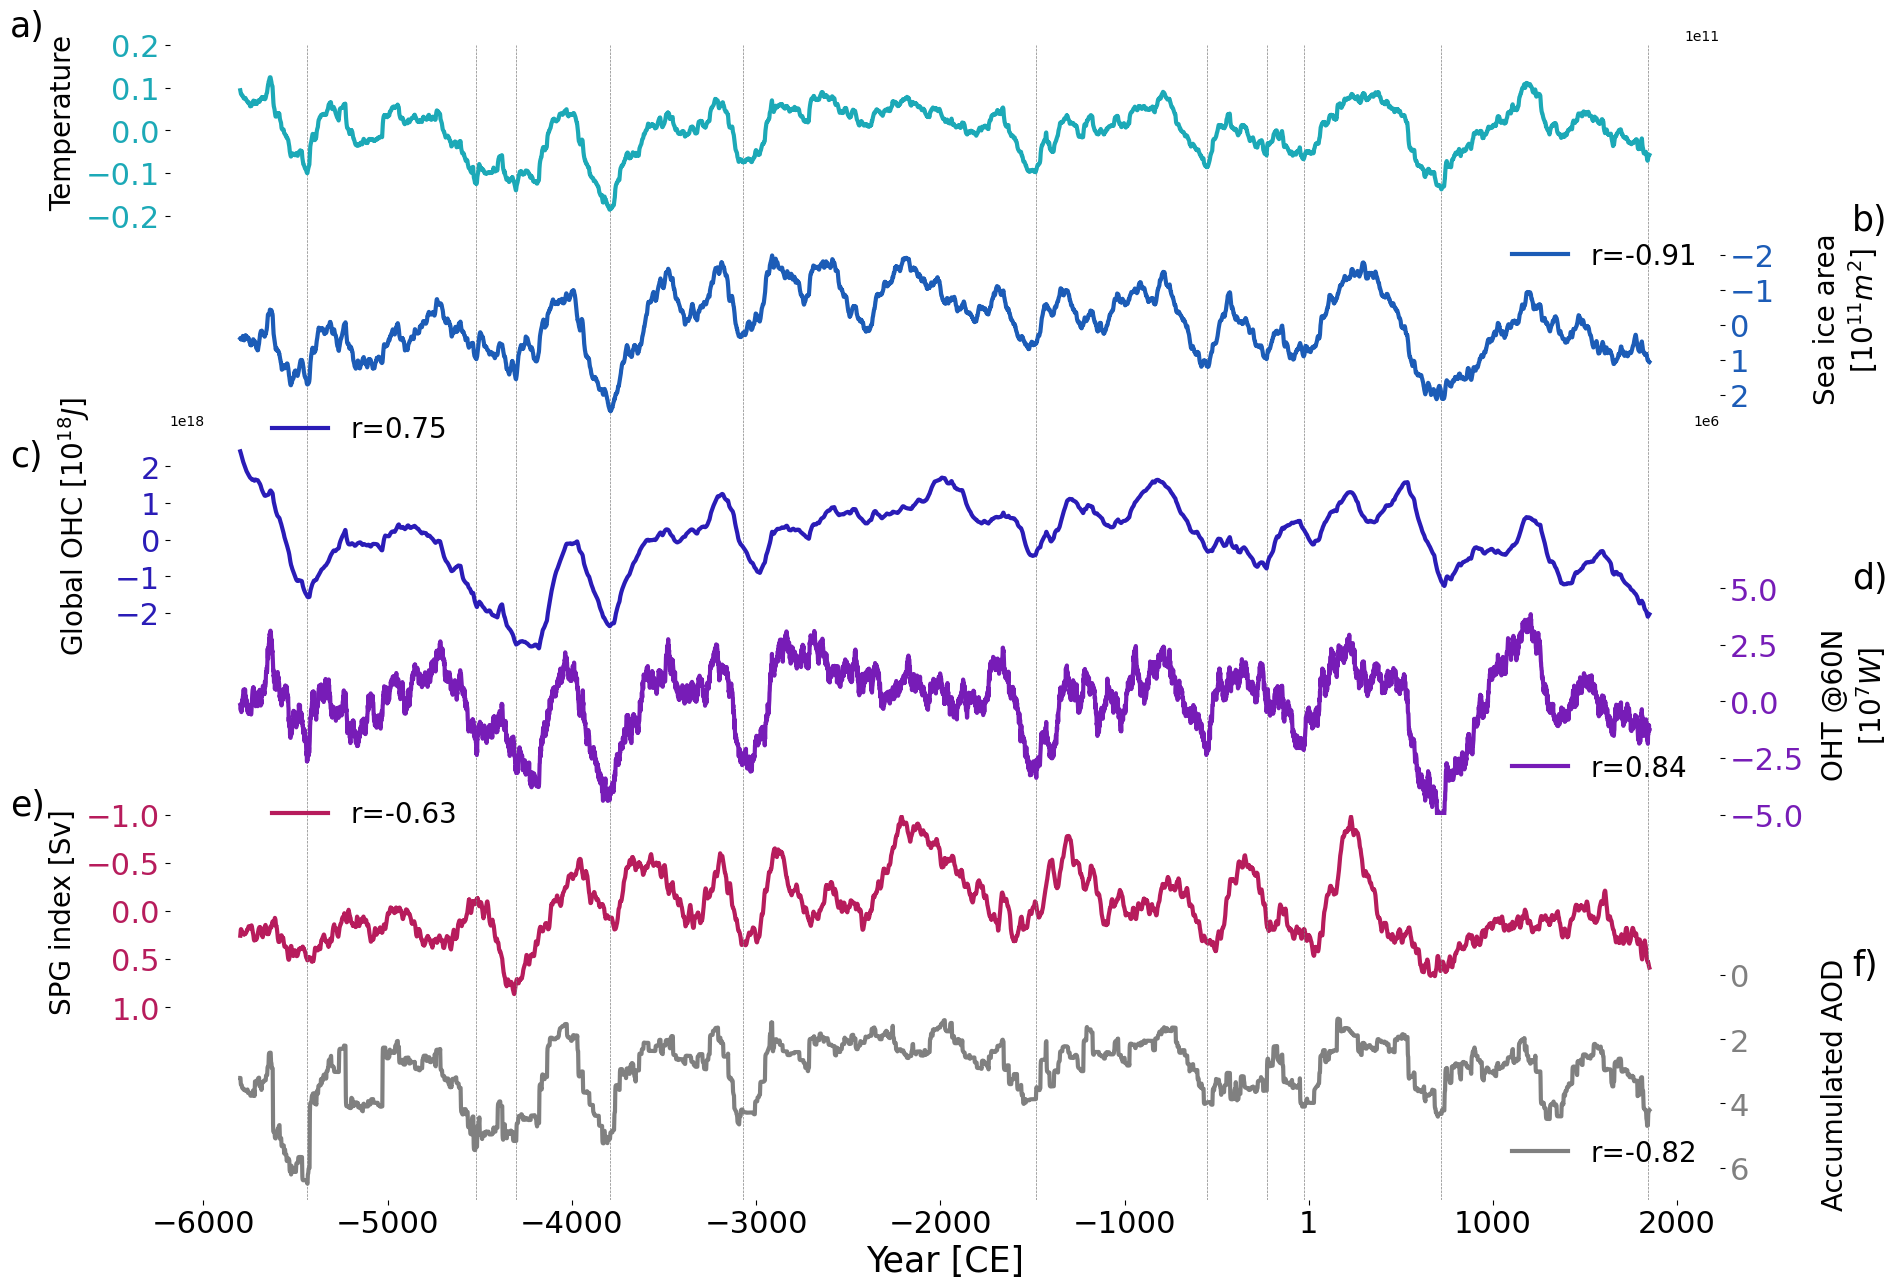

In [26]:
fig, ax = plt.subplots(3,figsize=(20,15), sharex=True)
fig.subplots_adjust(hspace = 0.0)

for i in range(11):
    ax[0].axvline(time[peaks[i]]+100, linewidth=0.5, linestyle='dashed', color='grey')
 
ax[0].plot(time_200acc,tas_NH_detr_200yr[100:-100], linewidth=3, color = '#1ca9b7')
ax[0].set_ylim(-0.7,0.2)
ax[0].set_ylabel('Temperature', fontsize=20)
ax[0].tick_params(labelsize=22)
#ax[0].set_xticks([])
ax[0].set_yticks([-0.2,-.1,0,.1,.2])
ax[0].yaxis.set_label_coords(-.06,0.8)

ax[0].text(-7050,0.22,'a)', fontsize=25, color='black')

[t.set_color('#1ca9b7') for t in ax[0].yaxis.get_ticklabels()]

#----------------------------------------------------------------------------------------------------------
ax0 = ax[0].twinx()

ax0.plot(time_200acc,si_detr_200yr[100:-100,0,0], linewidth=3, color = '#1c5cb7', label='r=-0.91')

ax0.set_ylim(-8e+11,3e+11)
ax0.set_ylabel('Sea ice area \n [$10^{11} m^2$]', fontsize=20)
ax0.tick_params(labelsize=22)
ax0.set_yticks([-2e+11,-1e+11,0,1e+11,2e+11])
ax0.yaxis.set_label_coords(1.06,0.3)

ax0.invert_yaxis()

ax0.legend(loc=3, bbox_to_anchor=(0.85,0.35), fontsize=20, frameon=False)

ax0.text(2950,-2.7e+11,'b)', fontsize=25, color='black')

[t.set_color('#1c5cb7') for t in ax0.yaxis.get_ticklabels()]

#----------------------------------------------------------------------------------------------------------
#ax2 = ax[0].twinx()
for i in range(11):
    ax[1].axvline(time[peaks[i]]+100, linewidth=0.5, linestyle='dashed', color='grey')

ax[1].plot(time_200acc,ohc_detr_200yr[100:-100], linewidth=3, color = '#2a1cb7', label='r=0.75')

ax[1].set_ylim(-7.5e+18,3e+18)
ax[1].set_ylabel('Global OHC [$10^{18} J$]', fontsize=20)
ax[1].set_yticks([-2e+18,-1e+18,0,1e+18,2e+18])
ax[1].tick_params(labelsize=22)
ax[1].yaxis.set_label_coords(-.05,0.75)
ax[1].set_xlabel('Year [CE]', fontsize=25)
ax[1].legend(loc=3, bbox_to_anchor=(0.05,0.9), fontsize=20, frameon=False)

ax[1].text(-7050,2e+18,'c)', fontsize=25, color='black')

[t.set_color('#2a1cb7') for t in ax[1].yaxis.get_ticklabels()]

#----------------------------------------------------------------------------------------------------------
ax1 = ax[1].twinx()
ax1.plot(time_200acc,moc_60N_detr_200yr[100:-100], linewidth=3, color = '#771cb7', label='r=0.84')

ax1.set_ylim(-0.5e7,1.2e7)
ax1.set_ylabel('OHT @60N \n [$10^{7} W$]', fontsize=20)
ax1.set_yticks([-0.5e7,-.25e7,0,.25e7,.5e7])
ax1.tick_params(labelsize=22)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.yaxis.set_label_coords(1.065,0.3)

ax1.legend(loc=3, bbox_to_anchor=(0.85,0.02), fontsize=20, frameon=False)

ax1.text(2950,.5e7,'d)', fontsize=25, color='black')

[t.set_color('#771cb7') for t in ax1.yaxis.get_ticklabels()]

#----------------------------------------------------------------------------------------------------------
ax[2].plot(time_200acc,BTS_NA_detr_200yr[100:-100,0,0,0], linewidth=3, color = '#b71c5c', label='r=-0.63')

ax[2].set_ylim(-1,3)
ax[2].set_ylabel('SPG index [Sv]', fontsize=20)
ax[2].set_yticks([-1,-.5,0,.5,1])
ax[2].tick_params(labelsize=22)
ax[2].yaxis.set_label_coords(-.06,0.75)
ax[2].set_xlabel('Year [CE]', fontsize=25)

ax[2].invert_yaxis()

ax[2].legend(loc=3, bbox_to_anchor=(0.05,0.9), fontsize=20, frameon=False)

ax[2].text(-7050,-1,'e)', fontsize=25, color='black')

[t.set_color('#b71c5c') for t in ax[2].yaxis.get_ticklabels()]
#ax1.yaxis.set_label_coords(1.05,0.25)

#----------------------------------------------------------------------------------------------------------
ax2 = ax[2].twinx()

for i in range(11):
    ax2.axvline(time[peaks[i]]+100, linewidth=0.5, linestyle='dashed', color='grey')

ax2.plot(time_200acc,max_aod_acc_200yr[:], linewidth=3, color = 'grey', label='r=-0.82')

ax2.set_ylim(-5,7)
ax2.set_ylabel('Accumulated AOD', fontsize=20)
ax2.set_yticks([0,2,4,6])
ax2.tick_params(labelsize=22)
ax2.yaxis.set_label_coords(1.065,0.3)
ax2.set_xticks([-6000,-5000,-4000,-3000,-2000,-1000,1,1000,2000])

ax2.invert_yaxis()

ax2.legend(loc=3, bbox_to_anchor=(0.85,0.02), fontsize=20, frameon=False)

ax2.text(2950,0,'f)', fontsize=25, color='black')

[t.set_color('grey') for t in ax2.yaxis.get_ticklabels()]

sns.despine(left=True, bottom=True, right=True)

#plt.savefig('figures/timeseries_ocean_si_AOD_200ym_highcorr_v2.png', bbox_inches = 'tight')
